# Whole-Brain Models, Part 2

Modified version of the Jansen & Rit model [1] with inhibitory synaptic plasticity [2].
Two subpopulations of neural masses were used to simulate the neural activity of 
individual brain regions, according to [3].

Codes published in [4].

[1] Jansen, B. H., & Rit, V. G. (1995). Electroencephalogram and visual evoked
 potential generation in a mathematical model of coupled cortical columns. 
 Biological cybernetics, 73(4), 357-366.

[2] Abeysuriya, R. G., Hadida, J., Sotiropoulos, S. N., Jbabdi, S.,
Becker, R., Hunt, B. A., ... & Woolrich, M. W. (2018). A biophysical 
model of dynamic balancing of excitation and inhibition in fast 
oscillatory large-scale networks. PLoS computational biology, 14(2), 
e1006007.

[3] Otero, M., Lea-Carnall, C., Prado, P., Escobar, M. J., & El-Deredy, W. 
(2022). Modelling neural entrainment and its persistence: influence of 
frequency of stimulation and phase at the stimulus offset. Biomedical 
Physics & Engineering Express, 8(4), 045014. 

[4] Coronel‐Oliveros, C., Gómez, R. G., Ranasinghe, K., Sainz‐Ballesteros, A., 
Legaz, A., Fittipaldi, S., ... & Ibañez, A. (2024). Viscous dynamics associated 
with hypoexcitation and structural disintegration in neurodegeneration via 
generative whole‐brain modeling. Alzheimer's & Dementia.


@author: Carlos Coronel

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import JansenRitModelMulti as JR
import nibabel as nib
import nilearn.plotting as plotting
import nilearn.image as image
from nilearn import datasets

plt.rcParams.update({'font.size': 16})

#goodness of fit
#This is a tradeoff between euclidean distance and pearson correlation
def gof(FC_sim, FC_emp):
    
    corr = stats.pearsonr(FC_sim.flatten(), FC_emp.flatten())[0]
    mean_sim, mean_emp = np.mean(FC_sim), np.mean(FC_emp)
    mean_diff = np.abs(mean_sim - mean_emp) / mean_emp
    gof = corr * (1 - mean_diff)
    
    return(gof)
    
    
#Simulations parameters
JR.tmax = 30 #max sim time
JR.teq = 10 #eq time for reaching steady-state dynamics
JR.dt = 0.001 #integration step
JR.downsamp = 2 #downsampling for reducing memory consumption

#networks parameters
JR.M = np.load('SC_HCs.npy') #SC matrix
JR.nnodes = len(JR.M) #number of nodes
JR.norm = 1 #normalization factor

#Noise an inputs
JR.sigma = 2.5 #noise scaling factor
JR.p = 220 * np.ones(JR.nnodes) #inputs for individual nodes

#Plasticity
JR.plasticity_on = 1 #1: activated, 0: disabled
JR.target = 2.5 * np.ones(JR.nnodes) #target firing rate in Hz
JR.tau_p = 2 #time constant for plasticity (in seconds)

#Proportion of alpha neurons
JR.alpha = 0.5 * np.ones(JR.nnodes)
JR.gamma = 1 - JR.alpha

#updating some parameters
JR.update() #avoid this in extensive simulations (call it increases memory consumption).
            #just use it one time before parallelization



## Data description

Our mission is to analyze EEG functional connectivity (between 8 and 13 Hz, i.e., in the $\alpha$ range) in healthy controls (HCs) and patients with Alzheimer's disease (AD).

The functional connectivities (FCs) were constructed using Pearson correlation between the source time series.

The automated anatomical labeling (AAL) parcellation was employed, focusing only on the cortical regions plus the hippocampus and amygdala, encompassing a total of 82 brain areas.

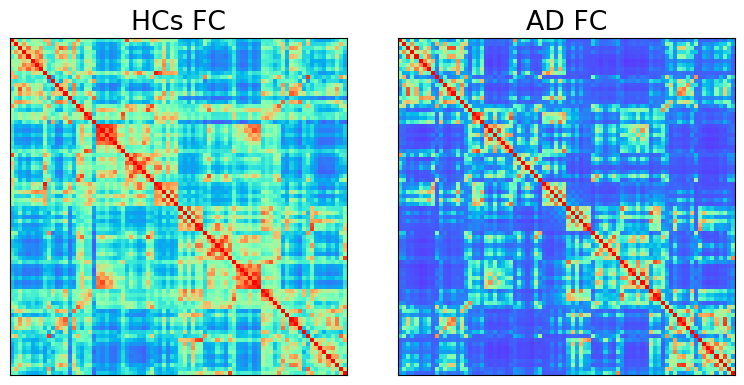

In [10]:
#Healthy controls (HCs)
FC_HCs = np.load('FC_HCs.npy') #Functional connectivity
SC_HCs = np.load('SC_HCs.npy') #Structural connectivity 
GMV_HCs = np.load('GMV_HCs.npy') #Gray matter volume
GMV_HCs = np.delete(GMV_HCs, np.arange(70,78,1))

#Patients with Alzheimer's disease (AD)
FC_AD = np.load('FC_AD.npy') #Functional connectivity
SC_AD = np.load('SC_AD.npy') #Structural connectivity
GMV_AD = np.load('GMV_AD.npy') #Gray matter volume
GMV_AD = np.delete(GMV_AD, np.arange(70,78,1))

plt.figure(1, figsize = (8,4))
plt.clf()

plt.subplot(1,2,1)
plt.imshow(FC_HCs, vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('HCs FC')

plt.subplot(1,2,2)
plt.imshow(FC_AD, vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('AD FC')

plt.tight_layout()



## Comparing simulated and empirical data

In this tutorial, we will explore how to adjust Functional Connectivity (FC) data using computational models by varying a parameter called Global Coupling. The objective is to compare simulated FC matrices with empirical FC matrices ucombining Pearson correlation and the difference in mean values of the matrices. The goal is to find the optimal Global Coupling value that maximizes this metric.

#### What is the global coupling?

Global Coupling is a parameter in computational models that influences the strength of connectivity across the entire network. By adjusting this parameter, we can simulate different levels of interaction between network nodes and study how these changes affect the FC.

#### Simulating FC Matrices

Using the Jasen & Rit model, we will generate simulated FC matrices by varying the Global Coupling parameter. Typically, you will run multiple simulations, each with a different value of Global Coupling, to cover a range of possible connectivity strengths.

#### Comparing Simulated and Empirical Matrices

To compare the simulated FC matrices with empirical FC matrices, we use a combined metric. This metric incorporates two components:
1. Pearson Correlation: Measures the linear correlation between corresponding elements of the simulated and empirical matrices.
2. Difference in Mean Values: Calculates the absolute difference between the mean values of the simulated and empirical matrices.

The combined metric is designed to capture both the similarity in patterns (correlation) and the overall magnitude differences (mean values) between the matrices.

<img src="inverted-U.png" width="350"/>

#### Optimization Process

As you increase the Global Coupling parameter, the combined metric typically forms an inverted U-shaped function. The task is to find the Global Coupling value that maximizes this combined metric, indicating the best match between simulated and empirical FC matrices.

To perform this optimization, you can use methods such as grid search or more sophisticated optimization algorithms. The key is to systematically vary the Global Coupling parameter and evaluate the combined metric for each value.



In [11]:
#Possibly global coupling values
K_vec = np.linspace(0,0.4,11)

#Goodness of fitt
gof_HCs = np.zeros_like(K_vec)
gof_AD = np.zeros_like(K_vec)

#FC matrices
FCs_HCs = np.zeros((82,82, len(K_vec)))
FCs_AD = np.zeros((82,82, len(K_vec)))

###FITTING HCs
for i in range(0, len(K_vec)):
    
    JR.K = K_vec[i] #Global coupling 
    JR.M = SC_HCs.copy() #structural connectivity
    JR.seed = 1 #random seed
    
    #Simulation starts here
    y, t = JR.Sim(verbose = False)
    #Simulations end here

    #EEG-like signals
    EEG = (JR.alpha * y[:,1,:] + JR.gamma * y[:,7,:]) - (JR.alpha * y[:,2,:] + JR.gamma * y[:,8,:])

    #filtering and computing FC
    fmin, fmax = 8, 13
    a0,b0 = signal.bessel(3, 2 * JR.dt * JR.downsamp * np.array([fmin, fmax]), btype = 'bandpass')

    Vfilt = signal.filtfilt(a0, b0, EEG, 0) #filtered signals
    FC = np.corrcoef(Vfilt.T) #functional connectivity
    
    #computing the gof
    gof_HCs[i] = gof(FC, FC_HCs)
    FCs_HCs[:,:,i] = FC.copy() #storing FC matrices
    
    print(i)

    

###FITTING AD
for i in range(0, len(K_vec)):
    
    JR.K = K_vec[i]
    JR.M = SC_AD.copy()
    JR.seed = 1
    
    #Simulation starts here
    y, t = JR.Sim(verbose = False)
    #Simulations end here

    #EEG-like signals
    EEG = (JR.alpha * y[:,1,:] + JR.gamma * y[:,7,:]) - (JR.alpha * y[:,2,:] + JR.gamma * y[:,8,:])

    #filtering and computing FC
    fmin, fmax = 8, 13
    a0,b0 = signal.bessel(3, 2 * JR.dt * JR.downsamp * np.array([fmin, fmax]), btype = 'bandpass')

    Vfilt = signal.filtfilt(a0, b0, EEG, 0) #filtered signals
    FC = np.corrcoef(Vfilt.T) #functional connectivity
    
    #computing the gof
    gof_AD[i] = gof(FC, FC_AD)
    FCs_AD[:,:,i] = FC.copy() #storing FC matrices
    
    print(i) #for impatient people...


0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10


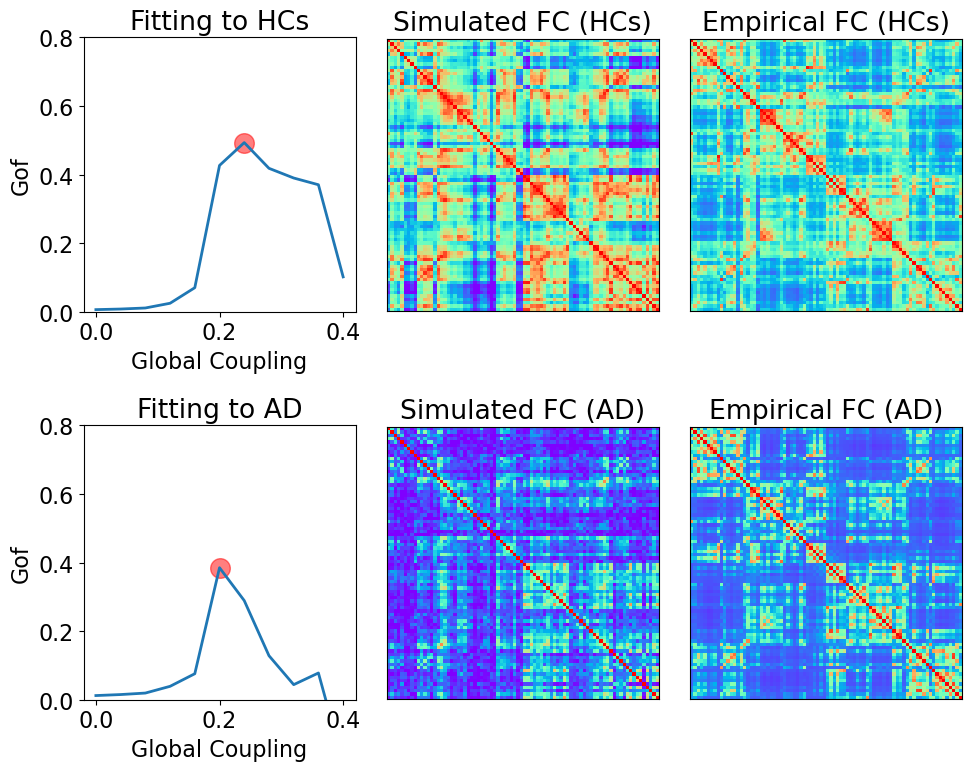

In [12]:
#Some plotting

plt.figure(1, figsize = (10,8))
plt.clf()

plt.subplot(2,3,1)
plt.plot(K_vec, gof_HCs, lw = 2)   
plt.xlabel('Global Coupling')
plt.ylabel('Gof')
plt.ylim(0,0.8)
plt.title('Fitting to HCs')
plt.scatter(K_vec[np.argmax(gof_HCs)], np.max(gof_HCs), s = 200, color = 'red', alpha = 0.5)

plt.subplot(2,3,2) 
plt.imshow(FCs_HCs[:,:,np.argmax(gof_HCs)], vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Simulated FC (HCs)')
    
plt.subplot(2,3,3) 
plt.imshow(FC_HCs, vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Empirical FC (HCs)')

plt.subplot(2,3,4)
plt.plot(K_vec, gof_AD, lw = 2)    
plt.xlabel('Global Coupling')
plt.ylabel('Gof')
plt.ylim(0,0.8)
plt.title('Fitting to AD')
plt.scatter(K_vec[np.argmax(gof_AD)], np.max(gof_AD), s = 200, color = 'red', alpha = 0.5)

plt.subplot(2,3,5) 
plt.imshow(FCs_AD[:,:,np.argmax(gof_AD)], vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Simulated FC (AD)')   
    
    
plt.subplot(2,3,6) 
plt.imshow(FC_AD, vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Empirical FC (AD)')

plt.tight_layout()



## Incorporating heterogeneities into the model

Incorporating heterogeneities into computational models of brain activity can significantly enhance the accuracy and specificity of simulations, especially when studying diseases like Alzheimer's that affect brain structure and function heterogeneously across different regions. A critical aspect of these heterogeneities is the variation in gray matter volumes (GMV), which can influence the excitatory/inhibitory (E/I) balance in different brain regions (see Moguilner at al. 2024, https://doi.org/10.1186/s13195-024-01449-0). 


To incorporate this aspect into a model, one can modify the local neuronal firing rates ($\rho_i$) based on the gray matter volume in each region using the following equation:

$$
\rho_i = \text{bias} + \text{scale} \times GMV_i
$$

Here, $\rho_i$ represents the pyramidal neurons' firing rate in the $i^{th}$ brain region, $GMV_i$ denotes the gray matter volume in that region, and 'bias' and 'scale' are parameters that adjust the base firing rate and the sensitivity of the firing rate to gray matter volume, respectively. This equation allows the model to account for regional differences in gray matter volume that could affect how neurons in those regions respond to synaptic inputs. For more infomation see Sanz Perl et al., (2023, https://doi.org/10.1162/netn_a_00299).

<img src="GM_WM.png" width="500"/>


In [14]:
#Best global coupling values for HCs and AD
K_HCs = K_vec[np.argmax(gof_HCs)]
K_AD = K_vec[np.argmax(gof_AD)]

#To store fitting results

gof_HCs_rE = np.zeros((9,9))
gof_AD_rE = np.zeros((9,9))

#Store FCs
FCs_HCs_rE = np.zeros((82,82,9,9))
FCs_AD_rE = np.zeros((82,82,9,9))

#E/I balance modulation
bias = np.linspace(2.4,2.6,9) #shared firing rates
scale = np.linspace(-0.1,0.1,9) #regional scaling of firing rates by GMV


###FITTING HCs
for i in range(0,9):
    for j in range(0,9):
    
        JR.K = K_HCs #global coupling
        JR.M = SC_HCs.copy() #structural connectivity matrix
        JR.seed = 1 #random seed
        
        #E/I balance
        JR.target = (bias[i] + scale[j] * GMV_HCs) * np.ones(JR.nnodes) 

        #Simulation starts here
        y, t = JR.Sim(verbose = False)
        #Simulations end here

        #EEG-like signals
        EEG = (JR.alpha * y[:,1,:] + JR.gamma * y[:,7,:]) - (JR.alpha * y[:,2,:] + JR.gamma * y[:,8,:])

        #filtering and computing FC
        fmin, fmax = 8, 13
        a0,b0 = signal.bessel(3, 2 * JR.dt * JR.downsamp * np.array([fmin, fmax]), btype = 'bandpass')

        Vfilt = signal.filtfilt(a0, b0, EEG, 0) #filtered signals
        FC = np.corrcoef(Vfilt.T) #functional connectivity

        gof_HCs_rE[i,j] = gof(FC, FC_HCs) #GOF
        FCs_HCs_rE[:,:,i,j] = FC.copy() #storing FCs
        
    print(i) #tic toc

    
###FITTING AD
for i in range(0,9):
    for j in range(0,9):
    
        JR.K = K_AD #global coupling
        JR.M = SC_AD.copy() #structural connectivity matrix
        JR.seed = 1 #random seed
        
        #E/I balance
        JR.target = (bias[i] + scale[j] * GMV_AD) * np.ones(JR.nnodes) 

        #Simulation starts here
        y, t = JR.Sim(verbose = False)
        #Simulations end here

        #EEG-like signals
        EEG = (JR.alpha * y[:,1,:] + JR.gamma * y[:,7,:]) - (JR.alpha * y[:,2,:] + JR.gamma * y[:,8,:])

        #filtering and computing FC
        fmin, fmax = 8, 13
        a0,b0 = signal.bessel(3, 2 * JR.dt * JR.downsamp * np.array([fmin, fmax]), btype = 'bandpass')

        Vfilt = signal.filtfilt(a0, b0, EEG, 0) #filtered signals
        FC = np.corrcoef(Vfilt.T) #functional connectivity

        gof_AD_rE[i,j] = gof(FC, FC_AD) #GOF
        FCs_AD_rE[:,:,i,j] = FC.copy() #storing FCs
        
    print(i) #tic toc


0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8


Gof difference in HCs = 0.149
Gof difference in AD = 0.206


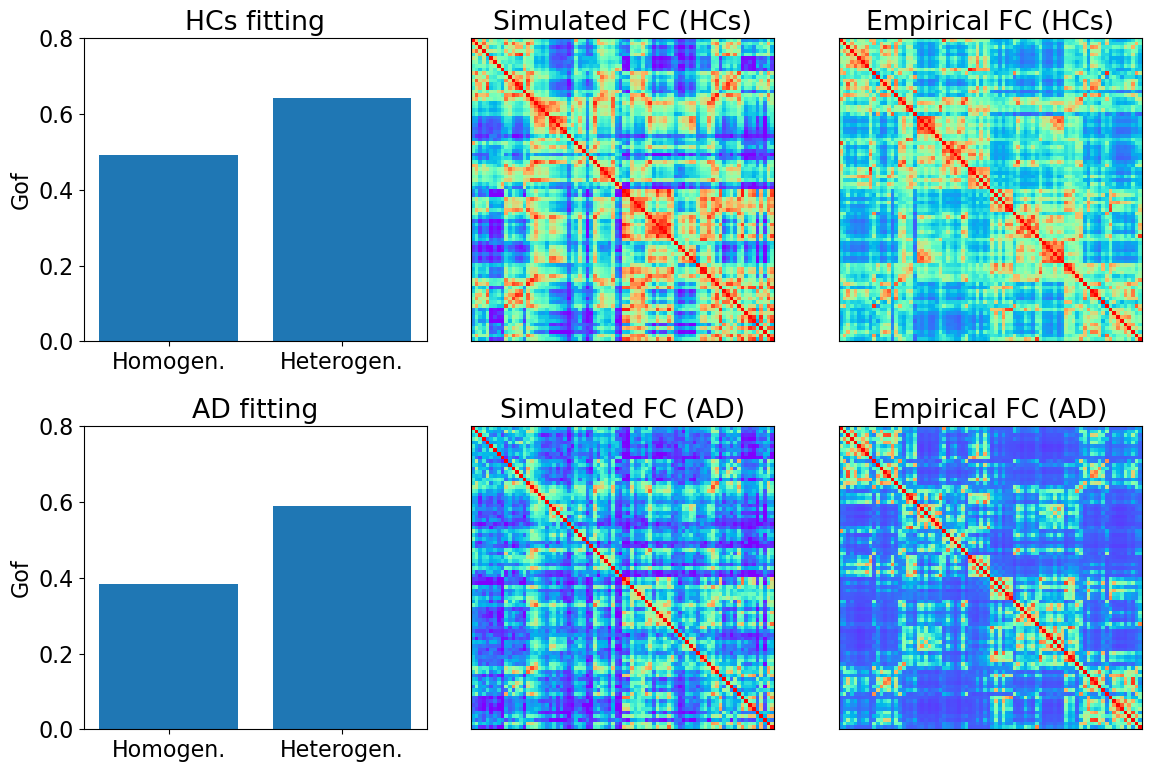

In [17]:
#Plotting

plt.figure(1, figsize = (12,8))
plt.clf()

plt.subplot(2,3,1)
plt.bar([1,2], [np.max(gof_HCs), np.max(gof_HCs_rE)])   
plt.ylabel('Gof')
plt.xticks([1,2], ['Homogen.', 'Heterogen.'])
plt.title('HCs fitting')
plt.ylim(0,0.8)

plt.subplot(2,3,2) 
plt.imshow(FCs_HCs_rE[:,:,gof_HCs_rE == np.max(gof_HCs_rE)], vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Simulated FC (HCs)')
    
plt.subplot(2,3,3) 
plt.imshow(FC_HCs, vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Empirical FC (HCs)')

plt.subplot(2,3,4)
plt.bar([1,2], [np.max(gof_AD), np.max(gof_AD_rE)])   
plt.ylabel('Gof')
plt.xticks([1,2], ['Homogen.', 'Heterogen.'])
plt.title('AD fitting')
plt.ylim(0,0.8)

plt.subplot(2,3,5) 
plt.imshow(FCs_AD_rE[:,:,gof_AD_rE == np.max(gof_AD_rE)], vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Simulated FC (AD)')               
    
plt.subplot(2,3,6) 
plt.imshow(FC_AD, vmin = 0, vmax = 1, cmap = 'rainbow')
plt.xticks([])
plt.yticks([])
plt.title('Empirical FC (AD)')

plt.tight_layout()


print('Gof difference in HCs = %.3f'%(np.max(gof_HCs_rE) - np.max(gof_HCs)))
print('Gof difference in AD = %.3f'%(np.max(gof_AD_rE) - np.max(gof_AD)))


## Regional differences between AD and HCs

Text(0.5, 1.0, 'E/I balance AD versus HCs')

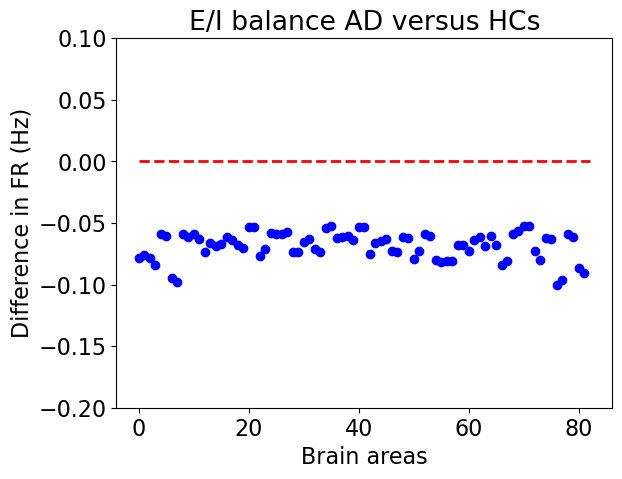

In [29]:
plt.figure(1)
plt.clf()

rE_HCs_idxs = np.argwhere(gof_HCs_rE == np.max(gof_HCs_rE))
rE_HCs = np.array(bias[rE_HCs_idxs[0][0]] + scale[rE_HCs_idxs[0][1]] * GMV_HCs)
rE_AD_idxs = np.argwhere(gof_AD_rE == np.max(gof_AD_rE))
rE_AD = np.array(bias[rE_AD_idxs[0][0]] + scale[rE_AD_idxs[0][1]] * GMV_AD)

plt.plot(rE_AD - rE_HCs, 'bo')
plt.ylabel('Difference in FR (Hz)')
plt.xlabel('Brain areas')
plt.ylim(-0.2,0.1)
plt.hlines(0, 0, 82, ls = 'dashed', color = 'red', lw = 2)
plt.title('E/I balance AD versus HCs')



# Regional changes

The areas that are more likely to be colored red and orange indicate regions where AD patients exhibit lower firing rates compared to HCs, and include:


. **Parietal Lobes** - Particularly the posterior regions, which are involved in spatial orientation and navigation, areas which AD patients frequently find challenging.

3. **Frontal Cortex** - Involded in decision making, problem-solving, and planning.

These regions are crucial for cognitive functions and their decreased activity aligns with the symptoms commonly observed in Alzheimer’s disease, such as memory loss, confusion, and difficulty with spatial awareness and logical reasoning.

Total AAL ROIs: 116
Saved: rE_difference_map_labels_82.nii.gz


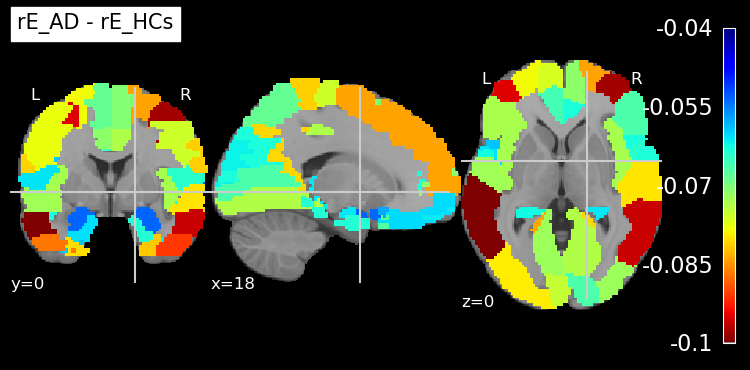

In [54]:
# === Load AAL parcellation ===
parcel_nii = nib.load('AAL.nii')
parcel_data = parcel_nii.get_fdata()

# === Extract all ROI labels (excluding background 0) ===
all_labels = np.unique(parcel_data)
all_labels = all_labels[all_labels != 0]  # Remove background
print(f"Total AAL ROIs: {len(all_labels)}")

# === Define the 82 ROIs you're using (labels, not indices) ===
# ROIs 0–89 excluding 70–77 → need to map to actual label values
full_roi_indices = np.array([i for i in range(90) if i < 70 or i > 77])
used_roi_labels = all_labels[full_roi_indices]  # These are the actual AAL label values for those ROIs

# === Sanity check ===
assert len(used_roi_labels) == 82, f"Expected 82 ROI labels, got {len(used_roi_labels)}"
assert len(rE_AD) == len(rE_HCs) == 82, "Mismatch in rE vector length"
difference_values = rE_AD - rE_HCs

# === Create brain map ===
roi_img_data = np.zeros_like(parcel_data)

for i, label in enumerate(used_roi_labels):
    mask = parcel_data == label
    roi_img_data[mask] = difference_values[i]

# === Save map ===
new_img = nib.Nifti1Image(roi_img_data, affine=parcel_nii.affine)
nib.save(new_img, 'rE_difference_map_labels_82.nii.gz')
print("Saved: rE_difference_map_labels_82.nii.gz")

# === Plot ===
bg_img = datasets.load_mni152_template()

plotting.plot_stat_map(
    new_img,
    title='rE_AD - rE_HCs',
    display_mode='ortho',
    cut_coords=(18, 0, 0),
    cmap='jet_r',
    threshold=-0.04,
    vmin=-0.1,
    vmax=-0.04,
    bg_img=bg_img
)
plotting.show()